In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from modules.rq_vae import RQ_VAE
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
import pandas as pd
from torch.amp import autocast, GradScaler

In [ ]:
embeddings = np.load('./data/ml-25m-vit_bert/embed_text.npy')

emb_shape = np.array(embeddings).shape
vae_input_dim = emb_shape[1]
vae_hidden_dims=[768, 512, 256]
vae_embed_dim=128

vae_codebook_size=256
dropout=0.1
vae_codebook_normalize=True
vae_sim_vq=False
vae_n_layers=3

use_kmeans_init=False

learning_rate=0.00001
weight_decay=0.1

batch_size=2048
commitment_weight=0.25
iterations=8000

embeddings = torch.tensor(embeddings, dtype=torch.float32)
train_loader = DataLoader(TensorDataset(embeddings), batch_size=batch_size, shuffle=True)

In [ ]:
model = RQ_VAE(
    input_dim=vae_input_dim,
    latent_dim=vae_embed_dim,
    hidden_dims=vae_hidden_dims,
    codebook_size=vae_codebook_size,
    codebook_kmeans=use_kmeans_init,
    codebook_normalization=vae_codebook_normalize,
    codebook_sim_vq=vae_sim_vq,
    num_layers=vae_n_layers,
    beta_commit=commitment_weight,
    num_cat_features=0,
)

scaler = GradScaler(device='cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

def train(num_epochs=250): 
    # Set up optimizer
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    epoch_progress = tqdm(range(num_epochs), desc="Training Progress")
    for epoch in epoch_progress:
        model.train()
        
        total_loss = 0
        total_reconstruction_loss = 0
        total_rqvae_loss = 0
        
        for _, (embeddings_batch,) in enumerate(train_loader):
            # Zero the gradients
            optimizer.zero_grad()
            embeddings_batch = embeddings_batch.to(device)
            # Forward pass
            # loss, reconstruction_loss, rqvae_loss, embs_norm, p_unique_ids
            with autocast('cuda' if torch.cuda.is_available() else 'cpu'):
                losses = model(embeddings_batch)

            scaler.scale(losses[0]).backward()
            scaler.step(optimizer)
            scaler.update()
            
            total_loss += losses[0].item()
            total_reconstruction_loss += losses[1].item()
            total_rqvae_loss += losses[2]
            
        epoch_progress.set_postfix({
            "Loss": f"{total_loss / len(train_loader):.4f}",
            "Reconstruction": f"{total_reconstruction_loss / len(train_loader):.4f}",
            "RQ-VAE": f"{total_rqvae_loss / len(train_loader):.4f}"
        })
        
do_train = True
if do_train:
    # Train the model
    train(iterations)
    torch.save(model.state_dict(), './models/rq-vae.pt')
else:
    # Load the model
    model.load_state_dict(torch.load('./models/rq-vae.pt'))

Training Progress:  21%|██        | 16643/80000 [3:01:00<11:29:05,  1.53it/s, Loss=412.2030, Reconstruction=412.2030, RQ-VAE=0.0000]


KeyboardInterrupt: 

In [61]:
sem_ids = []
interactions = pd.read_csv('./data/ml-25m-vit_bert/train.txt')
interactions = interactions.dropna()
num_users = interactions['user'].unique().shape[0]


for i in tqdm(range(59047)):
    song = embeddings[i].clone().detach().unsqueeze(0)
    song = song.to(device)
    with torch.no_grad():
        # embeddings, residuals, sem_ids, quantize_loss
        rqvae_output = model.get_semantic_ids(song, False)
        sem_ids.append(rqvae_output[2])
sem_ids_cpu = [tensor.cpu() for tensor in sem_ids]
sem_ids_cpu = np.array(sem_ids_cpu)[:,0,:]

100%|██████████| 59047/59047 [02:28<00:00, 397.28it/s]


In [62]:
def plot_sem_ids_3d(sem_ids_user):
    values = np.zeros((vae_n_layers, len(sem_ids_user)))
    
    for idx, tensor in enumerate(sem_ids_user):
        for i in range(vae_n_layers):
            values[i][idx] = tensor[i].item()
    
    plot_3d_scatter(values[0], values[1], values[2])

def plot_3d_scatter(x_values, y_values, z_values):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(x_values, y_values, z_values, c='blue', marker='o')
    
    ax.set_xlim(0, vae_codebook_size - 1)
    ax.set_ylim(0, vae_codebook_size - 1)
    ax.set_zlim(0, vae_codebook_size - 1)

    ax.set_xlabel('SID Axis 1')
    ax.set_ylabel('SID Axis 2')
    ax.set_zlabel('SID Axis 3')
    
    ax.set_title('3D Scatter Plot of SEM IDs')
    
    plt.show()
    
def find_sids_for_user(interactions, user_id, user_col_name, item_col_name):
    int_items = np.array(interactions.where(interactions[user_col_name] == user_id).dropna()[item_col_name].values, dtype=int)
    sids = []
    for items in int_items:
        sids.append(sem_ids_cpu[items])
        
    return np.array(sids)

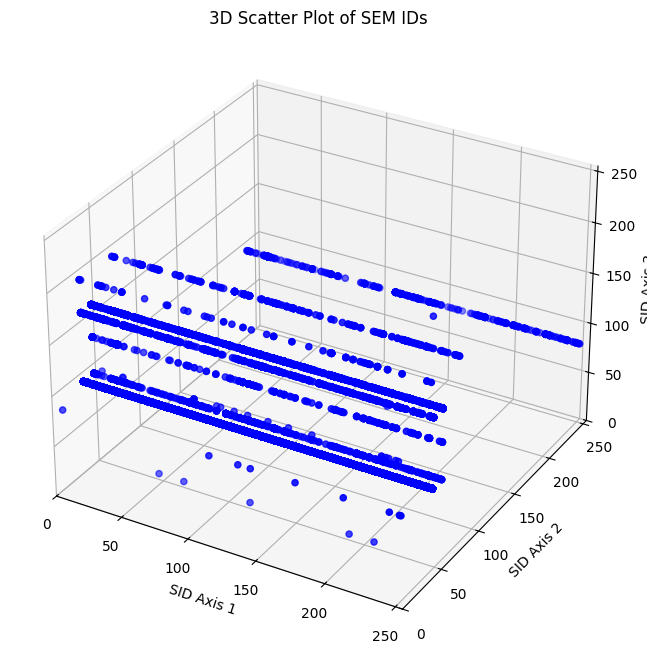

In [63]:
sem_ids_cpu

plot_sem_ids_3d(sem_ids_cpu)

[[1.         0.83744763 0.82186144 0.91030129 0.92266829 0.99994261
  0.9945706  0.96559816 0.88453807 0.84833804 0.52062815 0.5862181
  0.60170201]
 [0.83744763 1.         0.99961011 0.9885586  0.98342062 0.83154472
  0.88977363 0.95075369 0.99323027 0.99979513 0.90260653 0.93368997
  0.94040881]
 [0.82186144 0.99961011 1.         0.98396155 0.97797391 0.8157112
  0.87668321 0.94172875 0.99014752 0.99884017 0.91427396 0.9433242
  0.94953681]
 [0.91030129 0.9885586  0.98396155 1.         0.99952162 0.90581444
  0.94843583 0.98662737 0.99642787 0.99140915 0.82734903 0.86899506
  0.8783576 ]
 [0.92266829 0.98342062 0.97797391 0.99952162 1.         0.91848445
  0.95778529 0.99119638 0.99426926 0.98688961 0.80958145 0.85327562
  0.86315378]
 [0.99994261 0.83154472 0.8157112  0.90581444 0.91848445 1.
  0.99339868 0.96275694 0.87953819 0.84261729 0.51145167 0.57750527
  0.59311077]
 [0.9945706  0.88977363 0.87668321 0.94843583 0.95778529 0.99339868
  1.         0.98741623 0.92781026 0.898829

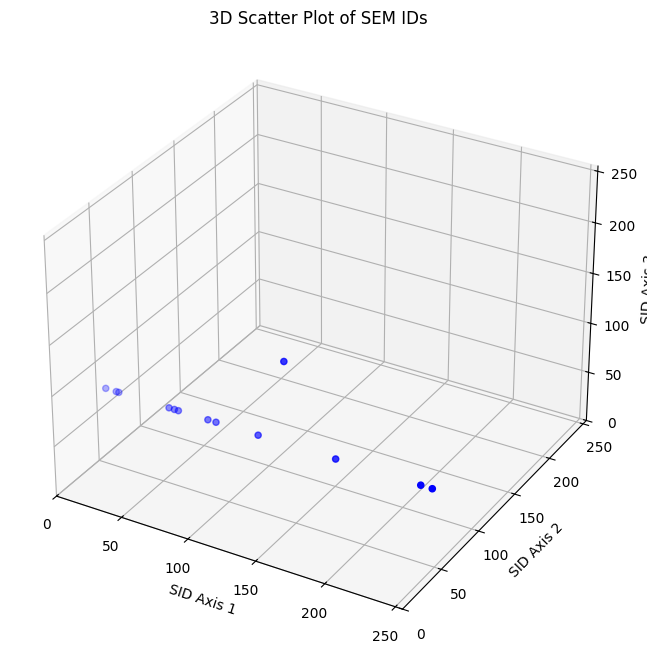

[[1.         0.99632727 0.90077504 0.9950089  0.99317677 0.99900933
  0.6805751  0.99596419 0.93273531 0.99541507 0.90780423 0.62836361
  0.93767039 0.60460701 0.84050667 0.99900933 0.99900933 0.89284115
  0.70149401 0.70149401 0.99874292 0.99900933 0.96755847 0.99535414
  0.99520716 0.66919181 0.99596419 0.99377991 0.99730831]
 [0.99632727 1.         0.86106634 0.98668769 0.97954341 0.99915074
  0.61533855 0.98462114 0.89843583 0.99994936 0.86855869 0.55944494
  0.90620164 0.53418257 0.79102695 0.99915074 0.99915074 0.85099805
  0.63789343 0.63789343 0.9907827  0.99915074 0.94296257 0.98345418
  0.98424557 0.60376034 0.98462114 0.99966561 0.99992381]
 [0.90077504 0.86106634 1.         0.91202333 0.94420397 0.88096498
  0.92451009 0.93529348 0.99346123 0.85598395 0.99601385 0.89671163
  0.97338346 0.88322099 0.98742968 0.88096498 0.88096498 0.99570417
  0.93484996 0.93484996 0.92095135 0.88096498 0.97080946 0.93751992
  0.92848859 0.92487651 0.93529348 0.84783164 0.86718087]
 [0.995008

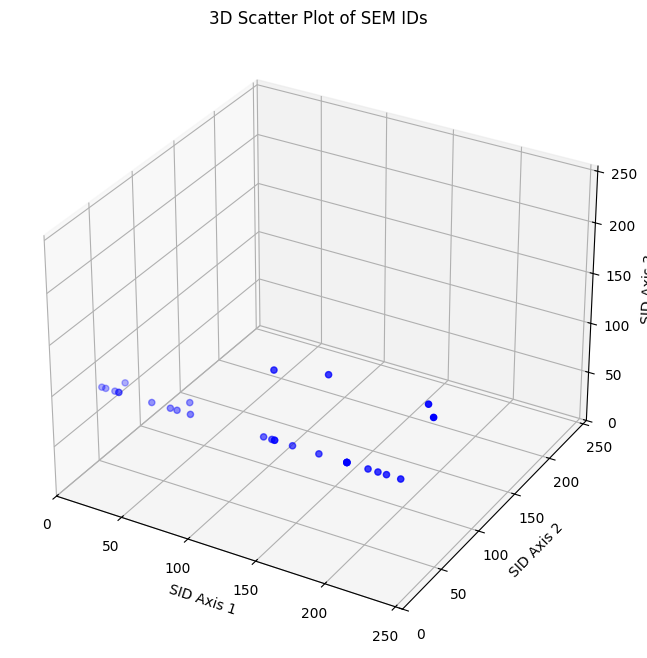

[[1.         0.54987763 0.55699854 0.99467648 0.54295135 0.65493326
  0.82581906 0.99467648 0.8527914  0.61948933 0.53455777 0.99093719
  0.96324858 0.54295135 0.82581906 0.50225967 0.54295135 0.99467648
  0.54295135]
 [0.54987763 1.         0.99996307 0.59979497 0.99996545 0.991217
  0.9246183  0.59979497 0.90362048 0.99627418 0.99983206 0.46173267
  0.74680362 0.99996545 0.9246183  0.99841618 0.99996545 0.59979497
  0.99996545]
 [0.55699854 0.99996307 1.         0.60664963 0.99985707 0.99231696
  0.92781026 0.60664963 0.90726837 0.99697858 0.99963764 0.46933899
  0.75249167 0.99985707 0.92781026 0.99789579 0.99985707 0.60664963
  0.99985707]
 [0.99467648 0.59979497 0.60664963 1.         0.59312271 0.70034366
  0.85493973 1.         0.88472008 0.66656745 0.58503053 0.9866966
  0.98006699 0.59312271 0.85493973 0.55382877 0.59312271 1.
  0.59312271]
 [0.54295135 0.99996545 0.99985707 0.59312271 1.         0.99008342
  0.92146592 0.59312271 0.90002859 0.99552284 0.99994986 0.45434309
  0

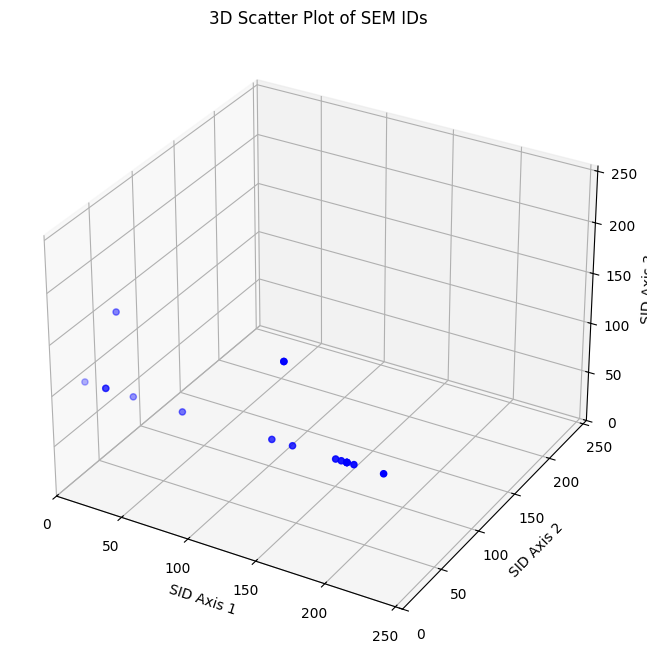

[[1.         0.84566966 0.83964979 ... 0.88006836 0.99159569 0.99357231]
 [0.84566966 1.         0.9999375  ... 0.99767613 0.76951387 0.77981876]
 [0.83964979 0.9999375  1.         ... 0.99685201 0.76232569 0.77277109]
 ...
 [0.88006836 0.99767613 0.99685201 ... 1.         0.81123847 0.82065924]
 [0.99159569 0.76951387 0.76232569 ... 0.81123847 1.         0.99986721]
 [0.99357231 0.77981876 0.77277109 ... 0.82065924 0.99986721 1.        ]]


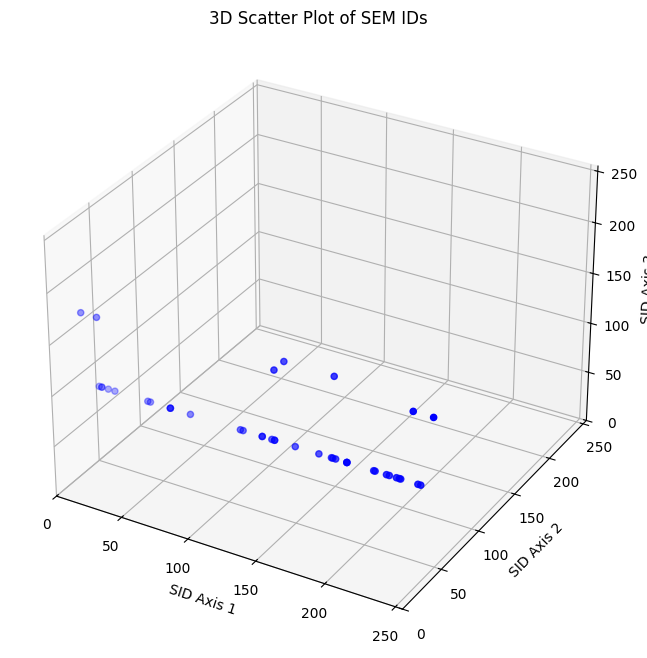

[[1.         0.99975706 0.59174276 0.55868693 0.99542823 0.5777646
  0.87595485 0.99970349 0.99832152 0.51166155 0.57538055 0.87595485
  0.8304703  0.99206301 0.99238422 0.98830496 0.91907355 0.74680362
  0.53762653 0.89202936 0.59979497 0.59979497 0.9246183  0.59979497
  0.59979497 0.99943784]
 [0.99975706 1.         0.60936716 0.57683187 0.99308117 0.59529128
  0.88637467 0.99999733 0.99680246 0.53016252 0.59326812 0.88637467
  0.84243678 0.99459352 0.99413744 0.99142596 0.92753647 0.7612807
  0.55576416 0.90177487 0.61728576 0.61728576 0.93266748 0.61728576
  0.61728576 0.99845608]
 [0.59174276 0.60936716 1.         0.99918333 0.51204224 0.98803028
  0.90720997 0.61119651 0.54406274 0.98395984 0.999797   0.90720997
  0.93645772 0.68840989 0.66017498 0.70774886 0.86153846 0.97802597
  0.98626672 0.89220307 0.99994974 0.99994974 0.84973667 0.99994974
  0.99994974 0.56438385]
 [0.55868693 0.57683187 0.99918333 1.         0.4769167  0.987569
  0.88947105 0.57871666 0.50971577 0.9866945 

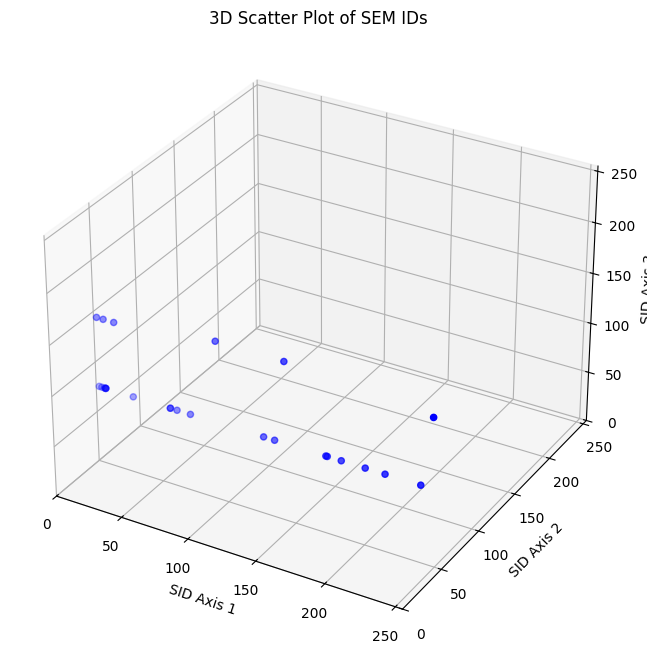

In [64]:
for i in range(5):
    user_id = np.random.randint(0, 59047)
    sids = find_sids_for_user(interactions, user_id, 'user', 'item')
    mat = cosine_similarity(sids, sids)
    print(mat)
    plot_sem_ids_3d(sids)